# GG4257 - Urban Analytics: A Toolkit for Sustainable Urban Development
## Lab Workbook No 3: Geovisualization Techniques - Data Viz.
---
Dr Fernando Benitez -  University of St Andrews - School of Geography and Sustainable Development - Iteration 2024

# Objectives

By the end of this practical lab, you will be able to:

* Create summary descriptive statistics for numeric attributes
* Generate frequency tables
* Use aggregation functions
* Write a basic user function
* Convert between co-ordinate reference systems
* Create contextual statistics for geographic features using buffers
* Handle and Map big data sets using additional libraries and frameworks



> **GOOD ACADEMIC PRACTICE**: As always, The University policy on Good Academic Practice applies. There are probably many ways to address the challenges in here or part of them. You are free to do research and find relevant resources, like the documentation website, if you cited them correctly. But I strongly advise not to use AI tools, most importantly because you won't learn/practice as you are supposed to.
>
> If you still insist on using AI tools, you must cite any code or work you are taking/adapting from it. However, if cited correctly, your mark will be lower, and if not cited correctly, you risk incurring academic misconduct.
>
>  If you are not aware of **our academic misconduct policy**, kindly take a quick look (Pag 8. https://www.st-ndrews.ac.uk/policy/academic-policies-assessment-examination-and-award-good-academic-practice/good-academic-practice-guidance-for-students-frequently-asked-questions.pdf)


# Basic numeric summary statistics

In the first part of this practical, we will import some [Airbnb](http://insideairbnb.com/get-the-data.html) data for Amsterdam that was collected during July 2016. Adapted from (Singleton, 2017)
 

In [ ]:
import pandas as pd

listings =pd.read_csv("data/Lab3/listings.csv")


#Show column headings
listings.head()

However, for this practical, we will subset these data to a limited set of variables; in the previous example, we used a list or Dict to define a new subset of columns; here, you have another method.

In [ ]:
# Subset data
subset_listings = listings[['id', 
                            'neighbourhood_cleansed',
                            'latitude',
                            'longitude',
                            'property_type',
                            'room_type',
                            'bedrooms',
                            'price',
                            'number_of_reviews']]

# We need to do some cleaning...There are some weird characters $ and , then convert the outcome to a dtype numeric.
# I use multiple functions in one line, but the key is using .loc and replace., check this link for more information.
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.loc.html
subset_listings.loc[subset_listings.index, 'price'] = subset_listings['price'].replace('[\$,]', '', regex=True).astype(float)

# Remove any records that are not complete
subset_listings = subset_listings.dropna()

# Let's see the results.
subset_listings.head()

In [ ]:
subset_listings.dtypes

The simplest way to create a set of descriptive statistics is to use the **describe()** function which returns the minimum, maximum, first and third quartile, and the mean and median for each column. For non numeric columns (e.g. neighbourhood_cleansed),the frequencies of the top seven most frequent attributes are shown.

In [ ]:
# Generate descriptive statistics
descriptive_stats = subset_listings.describe()
descriptive_stats

In [ ]:
descriptive_stats_non_numerical = subset_listings.describe(exclude='number')
descriptive_stats_non_numerical

# Frequency tables

Another common fundamental analysis task is to create a frequency table for a categorical variable - for example, the number of listings per neighbourhood. This can be achieved using the value_counts() function, which prints a list of the unique attributes and the frequency of these observations.


In [ ]:
neighborhood_counts = subset_listings['neighbourhood_cleansed'].value_counts()
neighborhood_counts

It is also possible to create cross-tabulations; showing the frequency of two attributes - here we look at neighborhood and bedrooms:

In [ ]:
# Here for the complete doc https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.crosstab.html 
cross_tabulation = pd.crosstab(subset_listings['neighbourhood_cleansed'], subset_listings['bedrooms'])
cross_tabulation

In [ ]:
cross_tabulation.info()

# Create aggregations and summary statistics

I have shown how you can use various descriptive summary functions for single columns, however, it is also possible to combine these with other functions which make these calculations within aggregations. This is especially useful for geographic application where you can create summaries by a defined area. In the following example I will use the function groupby() to find out what the mean price is by neighborhood:


In [ ]:
Sum_by_area = subset_listings.groupby('neighbourhood_cleansed')['price'].mean().reset_index()
Sum_by_area

>The `reset_index()` function in pandas is used to reset the index of a DataFrame. In Pandas when you apply the `group_by()` the resulting DataFrame often has a hierarchical index based on the grouping columns, making it a MultiIndex DataFrame., usually that is an issue.

In our analysis, we have so far only examined the average price. However, if we want to generate several different statistics for each aggregation, we can do so by creating a custom function. Throughout the labs, we have used various functions, some of which are built into the base version of Python, while others are available through libraries that we have loaded.

In this example, we create a new function called `data_description`, which calculates a mean and counts the number of records - these are stored within a new object called "stats", which is returned when the function is run.

In [ ]:
# data_description function
def data_description(x):
    stats = {'M': x.mean(), 'S': len(x)}
    return stats

In [ ]:
result = data_description(subset_listings.price)
print(result)

# Challenge 1

**What happens if you have non-numerical attributes?**

Please extend the `data_description` function to only accept numerical columns and calculate mean and counts. The outcome should be a table with Mean and Counts per Column.

> Tip: Check this function in pandas to filter the numerical values. https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.select_dtypes.html#pandas.DataFrame.select_dtypes
> Here some extra resources of creating function in python https://www.geeksforgeeks.org/python-functions/?ref=lbp


In [ ]:
#Add your code, here

# Spatial summary measures

So far we have considered a pre-defined geography in the previous example: neighborhoods. However, a common spatial analysis task is to create descriptive statistics related to the context of features. This task will typically require a buffer to be created around a feature and then data aggregated and summarized within the buffers.

First we will import a spatial data file that relates to [historic building locations](http://maps.amsterdam.nl/open_geodata/):


In [ ]:
import geopandas as gpd

# Recall here how to read external files in geopandas. https://geopandas.org/en/stable/docs/user_guide/io.html
historic_buildings = gpd.read_file("data/Lab3/historic_buildings.geojson", driver="GeoJSON")

historic_buildings.head()

Here is why I love python and GeoPandas, as the external file is GeoJSON including the geometry attribute, the result is already a spatial dataframe. That will be different in R where you need to locate the rows. 

In [ ]:
historic_buildings.explore()

In [ ]:
# We need to create a GeoDataFrame from the subset_listings
geometry = gpd.points_from_xy(subset_listings['longitude'], subset_listings['latitude'])
geo_listings = gpd.GeoDataFrame(subset_listings, geometry=geometry, crs=historic_buildings.crs)
geo_listings.explore()

In [ ]:
print(historic_buildings.crs)
print(geo_listings.crs)

Before making any spatial analysis we need to project the data

In [ ]:
projected_historic_buildings = historic_buildings.to_crs('EPSG:28992')
projected_geo_listings = geo_listings.to_crs('EPSG:28992')
print(projected_historic_buildings.crs)
print(projected_geo_listings.crs)

Now, lets make a buffer of 200m from all the historic buildings.

In [ ]:
historic_buffers = projected_historic_buildings.buffer(200)
historic_buffers.explore()

This outcome does not have an ID, so we can easily create one. Also, the outcome is a GeoSeries which cannot be used in a buffer analysis. You can transform it using the geometry values.

In [ ]:
historic_buffers['buffer_id'] = range(len(historic_buffers))
historic_buffers = gpd.GeoDataFrame(geometry=historic_buffers)
historic_buffers.head()

Running the spatial join to get the number of listings and their attributes per buffer area. More info here: https://geopandas.org/en/stable/docs/user_guide/mergingdata.html

In [ ]:
spatial_result =  projected_geo_listings.sjoin(historic_buffers, how="inner", predicate='intersects')
spatial_result.head()

To make things easier we can filter the buffer with more listings.

In [ ]:
listings_per_buffer = spatial_result.groupby('buffer_id').size().reset_index(name='listings_per_buffer')
listings_per_buffer

And now we can pick one of the buffer areas. For instance the 194.

In [ ]:
filtered_row = spatial_result[spatial_result['buffer_id'] == 194]
filtered_row.explore()

With this process now you can explore the prices, age, and other attributes related to the historic buldings and the AirBnb listings in Amsterdam., A useful excersice we can do is to plot for the random buffer area, plot th listings included in the areas and get the descritive estadistics. For example:

In [ ]:
historic_buffers.head()

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 8))

# We can plot the buffer areas and its listings
filtered_buffer = historic_buffers[historic_buffers['buffer_id'] == 194].plot(ax=ax, color="#D4D4D4", alpha=0.5)

# We can overlay all listings within the filtered buffer
filtered_row.plot(ax=ax, marker='o', color="#FF4500", markersize=5, alpha=0.7)

# Make the plot nicer
ax.set_title("Listings within Buffer - ID 194")
plt.show()

# Plot a histogram of the 'price' attribute
plt.figure(figsize=(6, 4))
filtered_row['price'].plot(kind='hist', bins=20, color='#FF4500', alpha=0.7)
plt.title('Distribution of Listings Prices within Buffer - ID 194')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()


In [ ]:
filtered_row.explore("price", cmap='Oranges', tiles='Esri_WorldGrayCanvas', zoom_start=17)
#See here all the list of Basemap ( tiles) options: https://leaflet-extras.github.io/leaflet-providers/preview/

# Folium 

Folium is a helpful library that facilitates the creation of interactive maps in Python. It allows you to visualize data on an interactive leaflet map, which can be easily manipulated. With Folium, you can bind data to a map for choropleth visualizations, and pass rich vector, raster and HTML visualizations as markers on the map. You can learn more about this library by visiting https://python-visualization.github.io/folium/latest/.




In [ ]:
import folium
from folium import plugins
from folium.plugins import MeasureControl
from branca.colormap import linear
from branca import colormap
from branca import colormap as cm

In [ ]:
lon, lat = -38.625, -12.875

zoom_start = 8

folium.Map(location=[lat, lon], tiles="OpenStreetMap", zoom_start=zoom_start)

In [ ]:
folium.Map(location=[lat, lon], tiles="Cartodb Positron", zoom_start=zoom_start)


In [ ]:
folium.Map(location=[lat, lon], tiles="Cartodb dark_matter", zoom_start=zoom_start)

https://leaflet-extras.github.io/leaflet-providers/preview/ Here you can get the list of all the supported tiles

In [ ]:
filtered_row.head()

In [ ]:
m = folium.Map([52.368152,4.897582], zoom_start=10)
location=filtered_row[["latitude","longitude"]]

plugins.MarkerCluster(location).add_to(m)
m

# Clic the cluster.

In [ ]:
folium.plugins.HeatMap(filtered_row[["latitude","longitude"]]).add_to(m)
m

# Challenge 2

Now is your turn to find, read, process and then make a comprehensive descriptive statistics analysis based on the previous resources and others you might need to look at. Create insightful visualizations combining both maps and charts to convey meaningful information about a chosen city.

1. Define a problem within the urban environment and choose a dataset related to urban life or city dynamics. This could include data on crime rates, housing prices, transportation, demographics, or any other urban-related dataset.
2. Get the data ideally using an **API, or web services**. But it's fine if you need to download the data. Describe why you had to use the traditional  method.
3. Work with the data cleaning and pre-processing, check for missing values, convert data types, and perform any other necessary preprocessing steps. You have the code for that in this and previous labs.
4. Use Pandas to calculate descriptive statistics such as `mean`, `median`, `standard deviation`, and other relevant measures. Explore `correlations` between different variables (Include at least one `univariate` and `bivariate` plots) 
6. Create at least one (or more) interactive map to visualize spatial aspects of the data. For example, plot crime rates across different neighbourhoods or visualize housing prices.
7. Complement with additional charts (line charts, bar charts, etc.) to extend the map and highlight key trends or patterns in the data.
8. As always, document well what you are doing and how you use `descriptive statistics and map visualizations` to extract insights from the data.
> You could try explaining any observed patterns, trends, or correlations, whether they are spatial or non-spatial. **Keep in mind** the defined problem and whether your analysis provides the required insights (Your conclusion could be that you need more data or another type of analysis)

# Dealing with big data sets

You have likely noticed the difficulties we face when attempting to plot data using traditional libraries with built-in mapping representation methods. Every time a new variable is loaded, your computer's memory pool becomes increasingly crowded. As spatial data scientists, we may end up consuming all of our available RAM, causing Jupyter to become stuck. Additionally, the notebooks become quite large in size, and it becomes difficult to push the final version into platforms like GitHub.

In such cases, desktop tools are typically more efficient when it comes to manipulating and handling a certain amount of data, but they, too, can become stuck. These programs, such as `QGIS`, `ArcGIS`, and even `R`, struggle to handle large datasets, especially those with over a million records. Therefore, we need to consider alternative methods for processing and plotting data.

> If you took the GG3209 module last semestre you will be familiar with this section

# Lonboard

Now, we can download big data sets related to reported crime in the UK. This data can be found in the following link https://data.police.uk/data/, you can select a range of times and then the force that you would like to get the data. For this example, we can download the reported crime from **Jan 2023 to Dec 2023** collected by the Metropolitan Police Service.

> Please **go to this website and download the data**, place the zip file in your data folder and keep working with the notebook. Once you unzip and merge all the files from Jan to Dec 2023, you should get approximately 1.135.031 records.

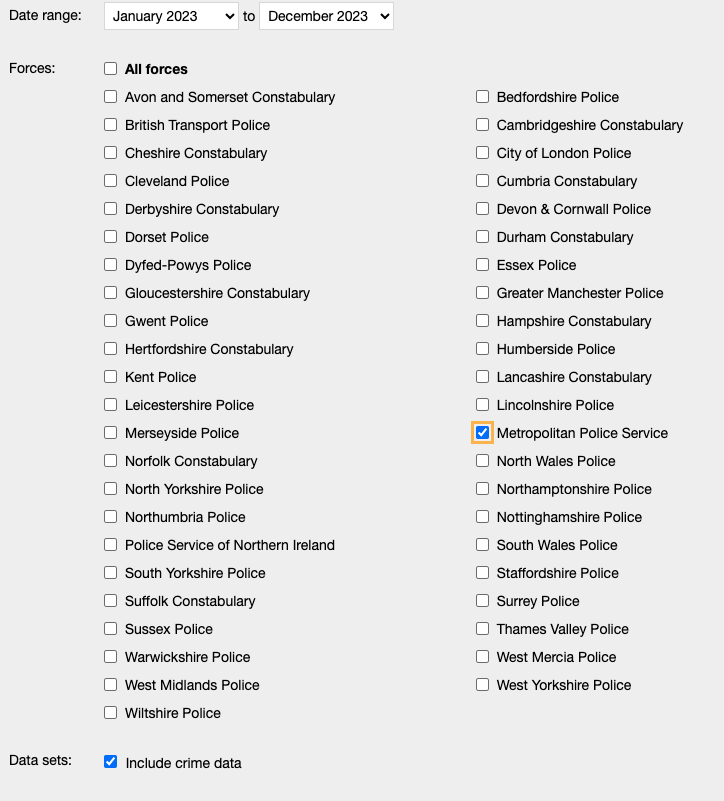



We need to unzip, go through all the sub-directories and then merge all the CSV files included.



In [ ]:
import zipfile
import os
import pandas as pd

# Unzip the file. YOU NEED TO UPDATE THIS PATH based on where you place the zip file.
with zipfile.ZipFile('data/Lab3/CrimeLondon.zip', 'r') as zip_ref:
    zip_ref.extractall('data/Lab3/CrimeData')

# List all .csv files in subdirectories
# Here we use https://docs.python.org/dev/library/pathlib.html and walk https://docs.python.org/dev/library/os.html#os.walk
csv_files = [os.path.join(root, file) for root, dirs, files in os.walk('data/Lab3/CrimeData') for file in files if file.endswith('.csv')]

# If you notice, the files are included in separate folders; we need to merge (concat) those.
crimes_london = pd.concat([pd.read_csv(csv_file) for csv_file in csv_files], ignore_index=True)

crimes_london.head()

You should have more than 1M of records.

In [ ]:
crimes_london.shape

In [ ]:
crimes_london.columns

Let's filter the requiered columns, and then geo-locate the outcome.

In [ ]:
subset_crimes = crimes_london[['Reported by', 
                            'Longitude',
                            'Latitude',
                            'LSOA code',
                            'LSOA name',
                            'Crime type',
                           ]]

# Remove any records that are not complete
subset_crimes = subset_crimes.dropna()
# We need a crime_id attribute.

subset_crimes['crime_id'] = range(len(subset_crimes))


In [ ]:
subset_crimes.head()


After the initial pre-processing, you have significantly less amount of data records. 







In [ ]:
subset_crimes.shape

In [ ]:
geometry = gpd.points_from_xy(subset_crimes['Longitude'], subset_crimes['Latitude'])
geo_crimes = gpd.GeoDataFrame(subset_crimes, geometry=geometry, crs='EPSG:4326')
geo_crimes.head()

To plot more than 1 million points, traditional methods are not a good choice. Instead, we can use advanced libraries like [lonboard](https://developmentseed.org/lonboard/latest/) to create a layer variable that utilizes the `geo_crimes` and plot it on an interactive map. This library offers two methods: `viz(gdf)` - a quick method to plot big datasets, and `ScatterplotLayer` - a method that provides more control over the layer's appearance. With this method, we can create a `layer` and customize its visualization using other methods in the library. Additionally, we can load several layers, including lines and polygons.

>Uncomment and run the next line once you install lonboard. Ideally this libary should be part of the UA environment we have or we can run the same line in another terminal, before lauching Jupyter.

In [ ]:
#pip install lonboard

In [ ]:
from lonboard import viz
viz(geo_crimes)

You are mapping more than 1M of records, if you want you can try that in QGIS or R and let me know the results

In [ ]:
from lonboard import Map, ScatterplotLayer

layer = ScatterplotLayer.from_geopandas(geo_crimes)
map = Map(layers=[layer], _height=500)
map

if you get an error, go to the documentation website and see what are you missing: https://developmentseed.org/lonboard/latest/api/layers/scatterplot-layer/

## Customizing the Layer

Now, we can customize the previous layer by plotting by `Crime type` in an initial attempt to unhide any spatial pattern. Let's initially check how many categories we have in this `Crime type` column.


In [ ]:
crime_type = geo_crimes['Crime type'].value_counts()
crime_type

In [ ]:
import seaborn as sns
geo_crimes.groupby('Crime type').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))

We can see that `Violence and sexual offences ` are the Crime Types with more reports. now, let's see if we can see any spatial pattern by plotting those categories in our previously loaded map. We need to assign a colour to each crime type to do this. We can do that by creating an array of all the unique categories.

In [ ]:
categories = geo_crimes['Crime type'].unique()
colors = sns.color_palette("bright", len(categories))
colors

Now using the same principle, we can use Numpy to create a matrix that group every `Crime type` with its correspondant `color code. ` This code will use the coding `RGBA(Red, Green, Blue,Alpha)` the last value corresponde to transparency.

In [ ]:
# Get unique categories
categories = geo_crimes['Crime type'].unique()

# colour seaborn's "tab10" color palette
colors = sns.color_palette("bright", len(categories))

# We create a dictionary to map categories to colours
color_dict = dict(zip(categories, colors))
color_dict

With this new array filled of the code colours we need per Crime type category. We can then use the layer. properties, e.g, `radius_scale`, `opacity`, and `get_fill_color`. You need to coe back to the map to see the customised layer in the map we plot previously.

In [ ]:
import numpy as np
color_array = np.array([tuple(np.append(
    np.multiply(
        color_dict.get(x, (0, 0, 0)), 255).astype(int), 255)) 
                        for x in geo_crimes['Crime type']],
                       dtype=np.uint8)
color_array

In [ ]:
layer.radius_scale = 40
layer.opacity = 0.05
layer.get_fill_color = color_array

> to see the updated and coloured map you need to scroll up and see the plot map we previously created.

The Metropolitan Police Service collects data from multiple areas, so the map includes data from areas outside London; we could define a new bounding box to focus only on the Central London area.

In [ ]:
geo_crimes.total_bounds

By using the tool https://norbertrenner.de/osm/bbox.html to get the precise boundary box you need to spatially filter your analysis and remove any outlier rows that are not located in the area of interest. 

In [ ]:
import shapely
ld_bbox = [-0.591,51.285,0.381,51.678] # London B. Box
geo_crimes_london = geo_crimes[geo_crimes.intersects(shapely.box(*ld_bbox))]
geo_crimes_london.shape

In [ ]:
layer = ScatterplotLayer.from_geopandas(geo_crimes_london)
map = Map(layers=[layer], _height=500)
map

# PyDeck

deck.gl is a **WebGL-powered** framework for visual exploratory data analysis of large datasets. You can install the entire framework on you computer an run it locally, which will be the rigth way if you are creating an app from scratch. Here we will use PyDeck, which is a set of Python bindings for making spatial visualizations with **deck.gl**, optimized for a Jupyter environment. See the documentation: https://pydeck.gl/

> First, we need to install the library in our UTA environment, something you are already familiar with. Uncomment the next code cell and run it only once.


In [ ]:
#pip install pydeck

If you have issues installing it, please visit: https://pydeck.gl/installation.html or ask for an appoinment to get extra help.

In [ ]:
import pydeck as pdk

# 2014 locations of car accidents in the UK
UK_ACCIDENTS_DATA = ('https://raw.githubusercontent.com/uber-common/'
                     'deck.gl-data/master/examples/3d-heatmap/heatmap-data.csv')

#This data has already been curated and adapted to this example. In the real world, you need to do the data cleaning and pre-processing part.

In [ ]:
# Define a layer to display on a map
layer = pdk.Layer(
    'HexagonLayer',
    UK_ACCIDENTS_DATA,
    get_position=['lng', 'lat'],
    auto_highlight=True,
    elevation_scale=50,
    pickable=True,
    elevation_range=[0, 3000],
    extruded=True,                 
    coverage=1)

In [ ]:
# Set the viewport location, see here for more properties https://pydeck.gl/view_state.html?highlight=viewstate#pydeck.bindings.view_state.ViewState
view_state = pdk.ViewState(
    longitude=-1.415,
    latitude=52.2323,
    zoom=6,
    min_zoom=5,
    max_zoom=15,
    pitch=40.5,
    bearing=-27.36)

In [ ]:
# Render
r = pdk.Deck(layers=[layer], initial_view_state=view_state)
r.to_html('MyGeoApp.html')
# NOTE: You are creating an HTML ( website with this app) so you can see them out of the Jupyter environment. 

# Challenge 3

1. Go to https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Crashes/h9gi-nx95/about_data 
2. Get the data for Motor Vehicle Collisions - Crashes Jan 2024. The dataset contains 2.06 M of records.
3. Use the API endpoint to map the data (e.g. https://data.cityofnewyork.us/resource/h9gi-nx95.json) 
   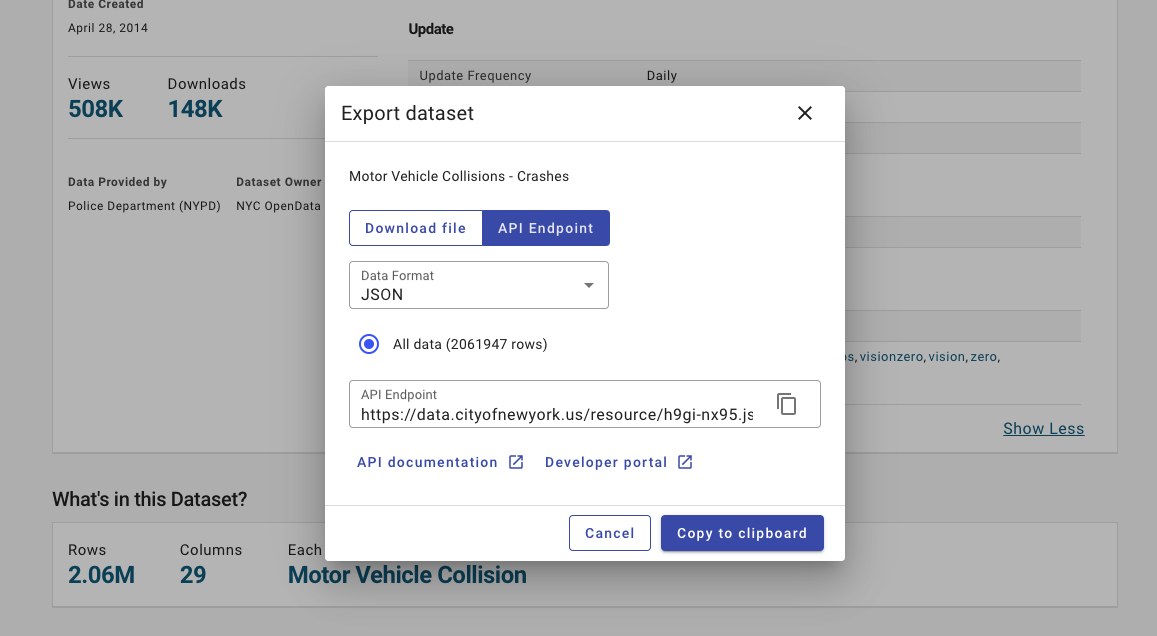
4. Customize the map by representing the data by `number_of_persons_killed` and `number_of_cyclist_killed`
5. Finally, calculate descriptive statistics for at least two attributes, such as `mean`, `standard deviation`, and other relevant measures 6. Justify/Describe the attribute selection.
7. Plot correlations between the chosen attributes and create `univariate` and/or `multivariate` charts to justify your insights.
   > Please take note that the dataset includes various numerical values. Hence, each student's attribute selection, justification, charts, and maps are expected to vary. 

# Datashader

Datashader is a graphics pipeline system for creating meaningful representations of large datasets quickly and flexibly. Datashader breaks the creation of images into a series of explicit steps that allow computations to be done on intermediate representations. 
There are other popular tools to represent big datasets like HoloViz; Datashader is included in this extended framework to allow researchers to represent millions of records.

## Why is mapping big data sets so complicated?

1. The speed. Plotting the 11 million data points from the below example using regular Python tools would be slow and may crash Jupyter kernel.
2. Image quality. In case a plotting library doesn't crash and you are willing to wait, it may still keep drawing each new data point as a circle or any other shape on top of each other, causing over-plotting. That is the main issue of plotting big data in GIS tools. Even if you add  transparency for overlapping points, it may not always help in this situation. Just imagine having many points displayed on top of each other on an image - what you would see it would become complicated to extract information from it.

**Datashader** provides an elegant and seemingly magic solution to these two obstacles. 


> Before you continue. I advise to save your work and **restart the kernel** as you must have a lot of your memory occupied.

Let's start with a simple example using data from the NYC Taxi data (https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page)

> For more info go to: https://examples.pyviz.org/nyc_taxi in here they use HoloViz, if time allow I will show you how to use that tool as well.

We need to make sure our Python env includes all the libraries we need. In a new terminal CD to your Working Directory/Repo and run 
`conda install holoviews hvplot datashader fastparquet python-snappy`

And then import packages:

In [ ]:
import holoviews as hv, pandas as pd, colorcet as cc
from holoviews.element.tiles import EsriImagery
from holoviews.operation.datashader import datashade
hv.extension('bokeh')

**Reading the data**:

For the very largest files, you will want to use a distributed processing library like **Dask with Datashader**, but here we have a **Parquet file** with “only” **11 million records**, which Datashader can easily handle on a laptop using Pandas without any special computing resources. Here you’ll load in two columns representing taxi drop-off locations.

In [ ]:
#GeoParquet is a helpful format for loading big data sets.

df = pd.read_parquet(
    'https://s3.amazonaws.com/datashader-data/nyc_taxi_wide.parq',
    columns = ['dropoff_x', 'dropoff_y']
)

In [ ]:
df.head() # This will take some time, you are loading more than 11M records.

In [ ]:
len(df)

**You have loaded 11M of records**, but now see how fast you will be able to plot all of them.

**Mapping**: 

Now we plot the data using **Datashader**. It only took four lines of code and six milliseconds to plot the 11 million rows of data, overlaid on a map of the New York area:

In [ ]:
%%time
map_tiles = EsriImagery().opts(alpha=0.5, width=900, height=480, bgcolor='black')
points = hv.Points(df, ['dropoff_x', 'dropoff_y'])
taxi_trips = datashade(points, cmap=cc.fire, width=900, height=480)
map_tiles * taxi_trips

Alternatively, instead of using **thedatashade function**, You could use **hvplot** with `rasterize=True` to apply rasterization using Datashader! 

I highly recommend using `hvplot` for your visualizations.

In [ ]:
import hvplot.pandas

map_tiles = EsriImagery().opts(alpha=0.5, width=900, height=480, bgcolor='black')
plot = df.hvplot(
    'dropoff_x',
    'dropoff_y',
    kind='scatter',
    rasterize=True,
    cmap=cc.fire,
    cnorm='eq_hist'
)
map_tiles * plot

You would then be able to `zoom in` to any region of this map, with the plot dynamically updating to use the full resolution for that zoom level.


**Datashader** turns your data into a plot using the five-step pipeline we discussed in the lecture.

You can find more information about how the pipeline works in each step on the Dashader Documentation site. (https://datashader.org/user_guide/Extending.html

1. Projection
2. Aggregation
3. Transformation
4. Colormapping and,
5. Embedding.

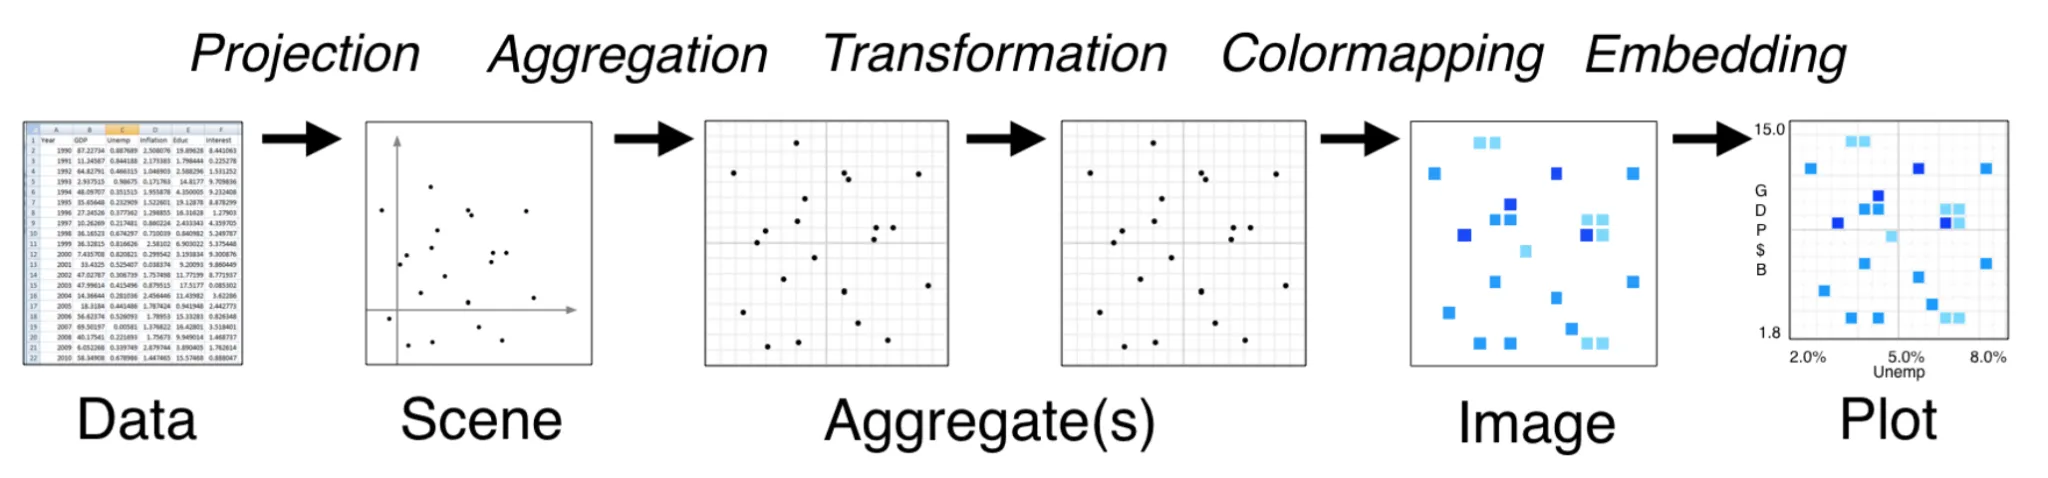
Fig 1. Datashader pipeline (Image from datashader.org).

Now we can break down each step you can see how the data is processed., Take some time to print and explore the outcomes.

In [ ]:
#Importing the required libraries.
import datashader as ds
import datashader.transfer_functions as tf
from holoviews.operation.datashader import rasterize

**Projection:** First, a 2D canvas is defined with width and height for the data to be projected onto.

The canvas defines **how many pixels** we would like to see in the final image, and optionally defines the `x_range` and `y_range` that will map to these pixels. 

In this particular scenario, the data ranges needed to plot are not specified in the Canvas. However, they will be automatically filled in the next step based on the maximum and minimum values of the data x and y in the given dataframe. The projection is defined by the Canvas, but for the sake of speed, each point is projected during the aggregation step.


In [ ]:
canvas = ds.Canvas(plot_width=900, plot_height=480)

**Agregation**: 

After we define the projected canvas, we project each point into the two-dimensional output grid and aggregate the results per pixel.

Datashader provides various options for data aggregation, but in this particular example, we are counting the number of data points projected into each pixel. To do this, we iterate through the data points and increment the pixel where the point lands. This creates a two-dimensional histogram that counts dropoffs per pixel.

In [ ]:
canvas.points(df, 'dropoff_x', 'dropoff_y', agg=ds.count())

**Transformation:** This is an optional step. 

The previous step has resulted in a fixed-size grid, regardless of the original dataset size. Once the data is in this grid, it can be transformed in any way desired, such as selecting a specific range of counts, masking data based on other datasets, or values, etc. In this case, the dropoff data ranges from zero in some pixels to tens of thousands in others. If we try to plot the grid directly, we would see only a few hotspots. Therefore, to make all the different levels visible, the data is transformed using the `image-processing` technique called **histogram equalization**. This technique reveals the distribution of the counts rather than their absolute values, making all the different levels visible, as seen in the image above.

Histogram equalization is actually folded into the colormapping step below, but we can do explicit transformations at this stage if we want, such as squaring the counts

In [ ]:
import numpy as np
np.power(canvas.points(df, 'dropoff_x', 'dropoff_y', agg=ds.count()),2)

**Color Mapping**

After the binning process, we can represent the binned grid data as an image. 

This is the key part, each bin value can be mapped to one of the 256 colors in a colormap, either through **linear interpolation** or an automatic transformation like applying the log function to each bin value, or using histogram equalization. 

In this example, we are using the "fire" colourmap from Colorcet. The colourmap starts with black for the lowest counts (1 and 2 dropoffs) and gradually shifts to red for higher values (in the hundreds), then yellow for even higher values (in the thousands), and finally white for the highest counts per pixel (in the tens of thousands, in this case). We set the background to black to enhance the visibility of the data.

Similar approach we did earlier with londboard

In [ ]:
import datashader.transfer_functions as tf
tf.set_background(
    tf.shade(
        canvas.points(df, 'dropoff_x', 'dropoff_y', agg=ds.count()),
        cmap=cc.fire),
    'black')

And **Embeedding:**

As you can see, Datashader only renders the data, not any axes, colour bars, or similar features you’d expect in a complete plot.

To add features that help interpret data, we can embed the images generated by Datashader into a plot. The easiest way to do this is to use **HoloViews**, which is a high-level plotting API that allows you to use `Matplotlib`, `Bokeh`, or `Plotly` as the backend. 

An example of using **HoloViews** to define a "points" object and then datashade all the points is shown below. Alternatively, you can use the **rasterize** method instead of **datashade** to let `Bokeh` handle the transformation and colormapping steps, enabling hover and colorbars to function properly.

In [ ]:
map_tiles = EsriImagery().opts(alpha=0.5, width=900, height=480, bgcolor='black')
points = hv.Points(df, ['dropoff_x', 'dropoff_y'])
ropts = dict(tools=['hover'], colorbar=True, colorbar_position='bottom', cmap=cc.fire, cnorm='eq_hist')
taxi_trips = rasterize(points).opts(**ropts)
map_tiles * taxi_trips

## Why Datashader is so fast?

Datashader is able to perform quickly because it uses **GeoParquet files**. If your data is in the form of JSON or CSV files, this can be memory-intensive. The Parquet file format is ideal for columnar data such as dropoff points, as it is compact, loads quickly, efficiently reads only the necessary columns and ranges, and supports distributed and out-of-core operation when required. 

The second reason for this fast representation is the combined **projection and aggregation** step. This step requires calculating values for millions of data points, but all subsequent calculations use the final fixed-size grid and are therefore much faster.


# Challenge 4

1. You worked with two modern libraries to map big data. Can you describe the differences between working with Longboard and Datashader? Which one provides the most exciting functionality, and how do the outcomes from both of them vary?
2. Find a large dataset with at least 5 million records. Consider open datasets, government datasets, or any dataset of interest to you. Ensure the dataset is in a format that can be easily loaded into a Pandas DataFrame (Parquet file or another format).
3. Define a potential problem or scenario for mapping this dataset.
4. Load the dataset into a Pandas DataFrame and explore its structure. Here, **I advice you! to take a small portion of that rather than work with the entire table.**
5. Identify key variables of interest that could be effectively visualized using Datashader(https://datashader.org/index.html#). (e.g. is fine if the datasets have only locations, but we are aiming for at least one additional variable to represent in the map. 
6. Use the previous steps and the Datashader documentation to implement a `hvplot` Map.
7. Discuss/Write any challenges you have encountered related to the challenges and how you addressed them.
8. As always. Provide clear comments and/or citations in your code, explaining each step of the Datashader implementation (**Note: You don't need to run the Datashader pipeline**)
   
9. **For next week**, create a **four-slide presentation** summarizing the problem, data source, dataset, challenges, map, and insights from visualizing the large dataset. **Two slides for Challenge 2** and the **other two for this challenge**. You can also use the Notebooks as a tool to make your presentation. 

# Finishing the Lab

Please ensure that you save all your code and upload the latest version of this notebook to your **GitHub repository**. Add also a PDF file with the presentation related to the T9 of challenge 4.

> Always check the size of your notebook before making any commit; make good use of the `.gitignore` to skip big data sets or undesired files.


# More resources

* [Stats Methods](http://www.statmethods.net/stats/descriptives.html) - some useful descriptions of various descriptive statistic methods / packages
* [Pandas cheat sheet](https://www.geeksforgeeks.org/pandas-cheat-sheet/) - lots of useful help and functions for working with spatial data
* [Urban Analytics Book](https://uk.sagepub.com/en-gb/eur/urban-analytics/book249267) - One of the most valuable and inital resources